In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

**TODO**
* Make tables pretty
* Figure out how and where to output data
* Purge irrelevant weather data
* Streamline the process, wrap it into async fastapi + docker

### Analysis itself

**Descriptive statistics**
* Mean, median rating
* Std. deviations of the rating
* Box plot of ratings
* Mean rating by the day (with $95\%$ confidence interval)
* ECDF for the rantings
* EWMA (+ raw points) over the whole observation time ($\alpha = 0.1$)
* (Spearman) correlation for ranking and weather conditions
* Figure out correlational (inflationary) relationships of the weather conditions

**Inductive statistics**
* Inference of distribution parameters for the rankings (assume gamma distibution)
* General additive model:
    * Fitted with `scipy.curve_fit`
    * Model of the form: $rating \sim \beta_0 + \sum_{i=1}^{n} f_i(weather~factor_i) + \varepsilon$
    * (With $95\%$ confidence interval of the prediction)

### Import

In [2]:
sunrise_set = pd.read_csv(
    "daily_data.csv",
    index_col="date",
    parse_dates=True
).drop(columns="Unnamed: 0").dropna(axis="index",how="any")

hourly_data = pd.read_csv(
    "hourly_data.csv",
    index_col="date",
    parse_dates=True
).drop(columns="Unnamed: 0").dropna(axis="index",how="any")

In [3]:
from datetime import datetime
sunrise_set.index = sunrise_set.index + pd.DateOffset(hours=2)
sunrise_set = sunrise_set.map(datetime.fromtimestamp)
sunrise_set.head(3)

,sunrise,sunset
date,,
2025-04-07 00:00:00+00:00,2025-04-07 06:39:03,2025-04-07 19:52:24
2025-04-08 00:00:00+00:00,2025-04-08 06:37:01,2025-04-08 19:53:51
2025-04-09 00:00:00+00:00,2025-04-09 06:35:01,2025-04-09 19:55:18


In [4]:
daily_data = hourly_data.resample("d").agg("mean")
daily_data.head(3)

,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation_probability,rain,showers,snowfall,cloud_cover,wind_speed_10m,surface_pressure
date,,,,,,,,,,
2025-04-24 00:00:00+00:00,10.122,79.083333,7.436648,36.041667,0.045833,0.087500,0.0,98.291667,12.322425,954.604186
2025-04-25 00:00:00+00:00,9.122,87.708333,7.116293,57.583333,0.033333,0.120833,0.0,98.666667,9.130855,955.840609
2025-04-26 00:00:00+00:00,10.397,77.916667,7.351045,15.541667,0.004167,0.012500,0.0,100.000000,14.697837,956.969212


In [5]:
db = pd.concat([sunrise_set, daily_data],axis="columns").dropna(axis="index",thresh=5)

In [6]:
# shape = 3
# scale = 1
# mean = shape * scale = 7
arr = np.random.gamma(shape=7,scale=1,size=len(db)).round(1)
ranks = np.where(arr > 10, 10, arr)
ranks

array([ 3.7,  2.8,  6.1,  3.9,  5.9,  9.3,  6.6,  6.9,  7.5,  6.9,  4.7,
        9.6,  6.7,  4.4,  6.3,  6.7,  4.4,  4.6,  7.4,  3.4,  5.7,  9.7,
        6.6,  7.8, 10. ,  7.1,  8.7,  8.1,  8.7,  5.5,  7.7,  2.7,  6.1,
        4. ,  7.2,  5.5, 10. ,  7.2,  4.5,  2.2,  8.5,  9.9,  7.3,  4. ,
        7.2,  4. ,  8.6, 10. ,  6.4,  5.5,  9.7,  6.3,  4.4,  7.4,  5.9,
        9. ,  4.3,  3.3,  4.4,  8.1,  3.9,  5.6,  5.5,  5.2,  5.6,  8. ,
        6.3,  4.6,  7.3,  6.5, 10. ,  8.1,  7.4,  8.8,  3.5,  6.4,  3.5,
        4.4,  4.6,  4.7,  6.1,  5. ])

In [7]:
db["day_rating"] = ranks
db.tail(3)

,sunrise,sunset,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation_probability,rain,showers,snowfall,cloud_cover,wind_speed_10m,surface_pressure,day_rating
date,,,,,,,,,,,,,
2025-07-12 00:00:00+00:00,2025-07-12 05:26:39,2025-07-12 21:11:59,17.348687,61.50,16.297848,5.875000,0.0,0.0,0.0,49.083333,7.565795,956.893855,4.7
2025-07-13 00:00:00+00:00,2025-07-13 05:27:39,2025-07-13 21:11:14,18.880167,60.75,18.798526,2.208333,0.0,0.0,0.0,42.333333,3.607636,954.616802,6.1
2025-07-14 00:00:00+00:00,2025-07-14 05:28:40,2025-07-14 21:10:26,22.105614,58.00,21.528886,12.727273,0.0,0.0,0.0,47.590909,10.958880,955.945861,5.0


### Analysis

In [33]:
# mean, median, std. deviation
srs = (db.day_rating
    .describe()
    .drop(["count","25%","50%","75%"])
)
srs["median"] = db.day_rating.median()

(pd.DataFrame(srs,index=srs.index)
    .reindex(["mean","median","std","min","max"])
    .T
    .style
    .format(precision=2, decimal=",")
    .format(lambda x: str(round(x,2)).replace(".",",") + " / 10", subset=["mean", "median", "min", "max"])
    .relabel_index(["Mean","Median","Standard deviation","Minimum","Maximum"],axis="columns")
    .relabel_index(["Value"],axis="rows")
    .set_properties(**{"text-align":"center", "font-weight": "bold"})
    .set_caption("<b>Quick stats for your ratings</b>")
    .hide(axis="index")  
)
# + Interpretaion through Chat

Mean,Median,Standard deviation,Minimum,Maximum
"6,32 / 10","6,3 / 10","2,02","2,2 / 10","10,0 / 10"


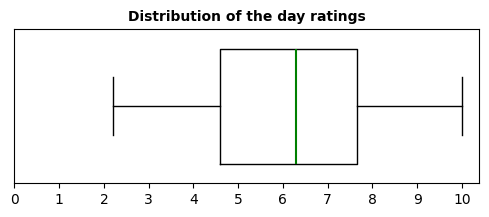

In [9]:
fig, ax = plt.subplots(figsize=(6, 2))
ax.boxplot(
    db.day_rating,
    orientation="horizontal",
    medianprops={"color":"green","linewidth":1.5},
)
ax.set_xticks(range(0,11))
ax.set_yticks([])
ax.set_ylim(0.9,1.1)
ax.set_title("Distribution of the day ratings", fontweight="bold",fontsize=10);
# + Interpretation through chat

In [10]:
# constant array warning
with warnings.catch_warnings(record=True):
    corrs = pd.DataFrame(db.drop(columns="day_rating").corrwith(db.day_rating,method="spearman"),columns=["Correlation"])

In [11]:
corrs.index.name = "Factor"
corrs = corrs.dropna()


(corrs
    .style
    .format_index(lambda x: x.replace("_"," ").capitalize(), axis="index")
    .format(lambda x: str(round(x,2)).replace(".",","))
    .set_properties(**{"text-align":"center", "font-weight": "bold"})
    .set_caption("<b>Spearman correlation of certain weather conditions with your rankings</b><br><br>*Factors which have not changed dunring the whole obseration time are ommited")
)

,Correlation
Factor,
Sunrise,"-0,06"
Sunset,"-0,06"
Temperature 2m,"0,09"
Relative humidity 2m,"-0,15"
Apparent temperature,"0,08"
Precipitation probability,"-0,11"
Rain,"-0,14"
Showers,"0,06"
Cloud cover,"-0,06"


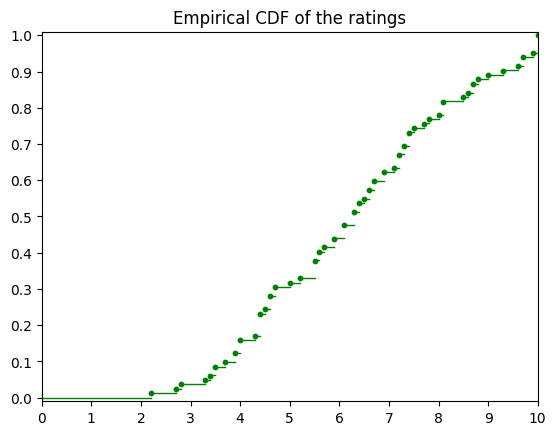

In [37]:
vals = db.day_rating.value_counts(normalize=True).sort_index().cumsum()

ax = plt.subplot()
ax.scatter(x=vals.index,y=vals.array,s=10,facecolors="green", edgecolors="green")
ax.set_xlim(0,10)
ax.set_xticks(np.arange(0,11,1))

ax.set_ylim(-0.01,1.01)
ax.set_yticks(np.arange(0,1.1,0.1))

for pair in vals.rolling(window=2):
    if len(pair) != 2: continue
    xmin, xmax = pair.index / (10)
    y = pair.iloc[0]
    ax.axhline(y=y+0.0005,xmin=xmin,xmax=xmax, color="green", linewidth=1)
ax.axhline(y=0,xmin=0,xmax=min(vals.index)/10,color="green", linewidth=1);

ax.set_title("Empirical CDF of the ratings");

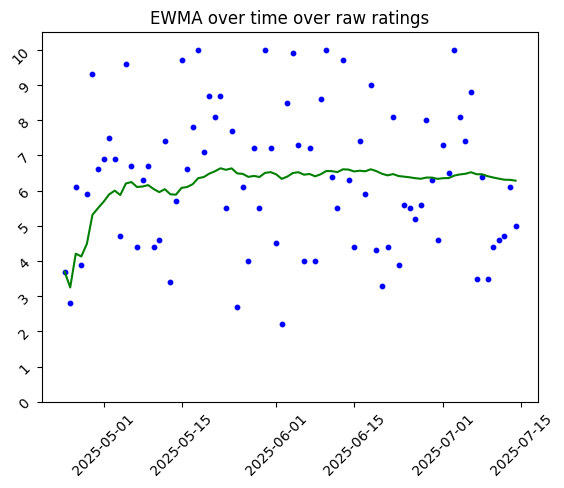

In [55]:
ewma = db.day_rating.ewm(alpha=0.01).mean()
raw_points = db.day_rating

ax = plt.subplot()
ax.plot(ewma, color="green")
ax.scatter(x=raw_points.index,y=raw_points.array,s=10,color="blue")
ax.set_ylim(0,10.5)
ax.set_yticks(np.arange(0,11,1))
ax.tick_params(rotation=45)
ax.set_title("EWMA over time over raw ratings");

In [66]:
mask = db.day_rating.index.strftime("%A")
db.day_rating.groupby(mask).median()

date
Friday       6.10
Monday       6.00
Saturday     7.05
Sunday       4.65
Thursday     5.90
Tuesday      6.70
Wednesday    6.50
Name: day_rating, dtype: float64

In [ ]:
for name, data in grouped_by_day:
    shape, _, scale = gamma.fit(data)
    ci_lower, ci_upper = gamma.interval(0.95,shape,scale)
    print(ci_lower, ci_upper)
    #gamma_estimates.loc["name"] = [shape, scale, ci_lower, ci_upper]

In [ ]:
# what is going on?
from scipy.stats import gamma 
grouped_by_day = db.groupby(db.index.strftime("%A"))["day_rating"]
gamma_estimates = pd.DataFrame(
    columns=["shape","scale","ci_lower","ci_upper"],
    index=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)